In [1]:
import pandas as pd
import seaborn as sns
import sys
from matplotlib import pyplot as plt

%matplotlib inline

MIN_PYTHON = (3, 6)
if sys.version_info < MIN_PYTHON:
    sys.exit("Python %s.%s or later is required.\n" % MIN_PYTHON)

In [7]:
df1 = pd.read_csv('part1.log.csv', 
                  index_col='TS', 
                  names=['TS', 'Speed', 'TLD', 'Location'], 
                  parse_dates=True)

df2 = pd.read_csv('part2.log.csv', 
                  index_col='TS', 
                  names=['TS', 'Speed', 'TLD', 'Location'], 
                  parse_dates=True)

# remove data outside of our test date range
df1 = df1.loc['2017-11-20':'2017-11-22']
df2 = df2.loc['2017-11-20':'2017-11-22']

Speed       1645
TLD         1645
Location     349
dtype: int64
Speed       1645
TLD         1645
Location     349
dtype: int64


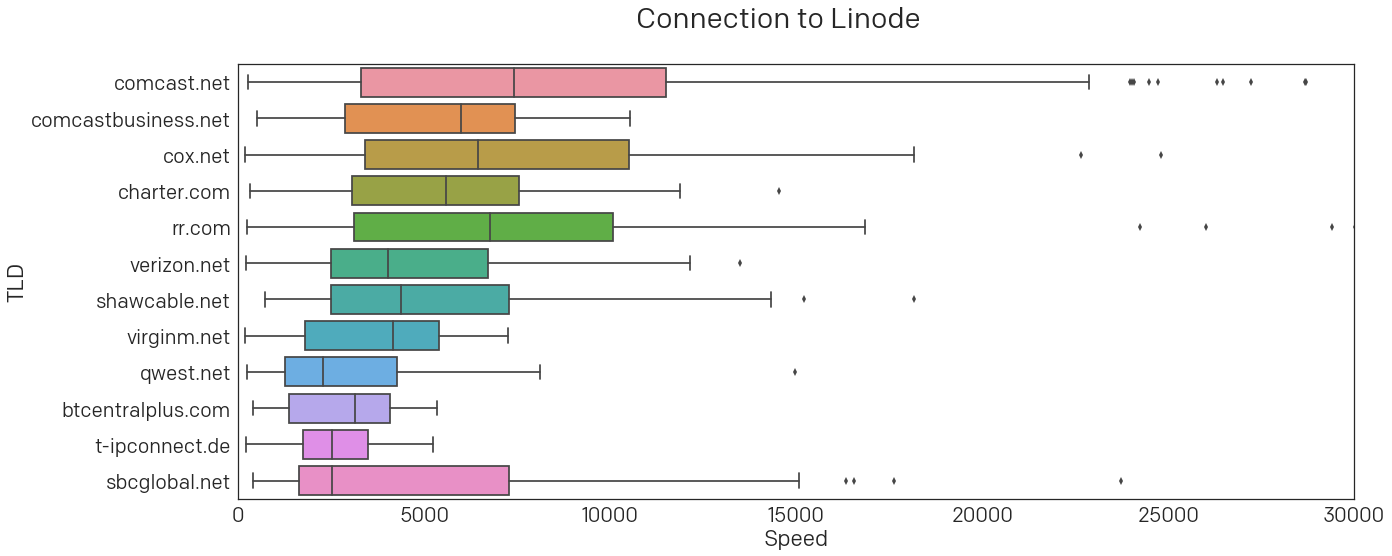

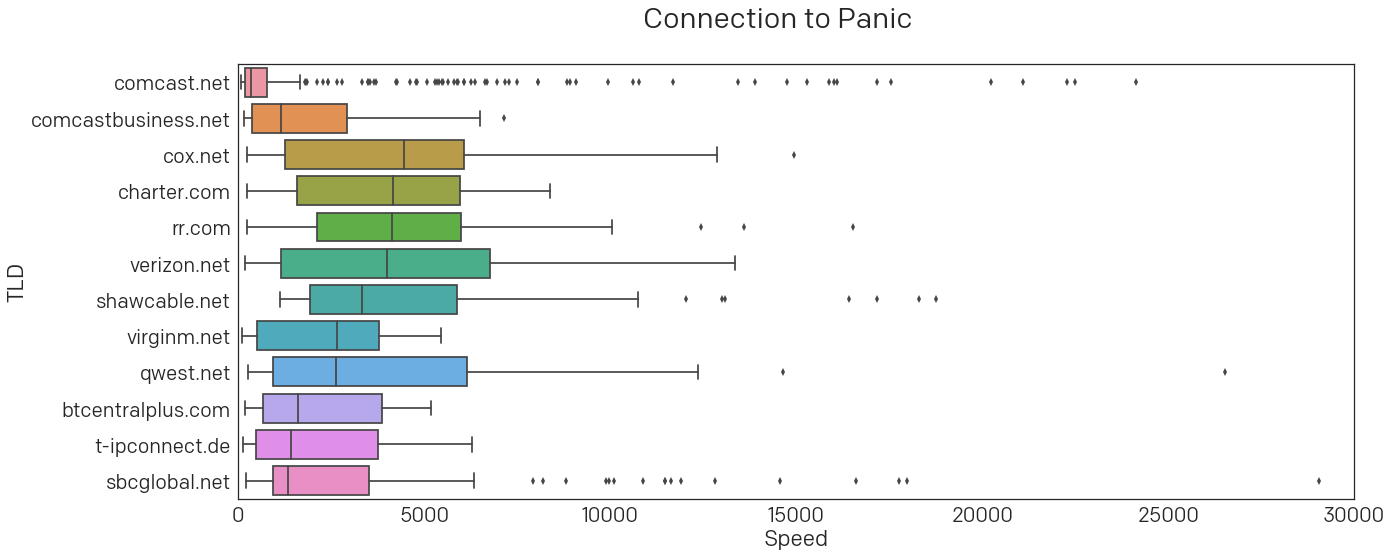

In [8]:
# remove rows from TLDs with low occurances
df1_c = df1[df1.groupby('TLD').Speed.transform(len) >= 10].copy(True)
df2_c = df2[df2.groupby('TLD').Speed.transform(len) >= 10].copy(True)

print(df1_c.count())
print(df1_c.count())

# The actual medians for comcast
# print(df1_c[df1_c['TLD'] == 'comcast.net'].median())
# print(df2_c[df2_c['TLD'] == 'comcast.net'].median())

# print(df1_c['TLD'].value_counts())
# print(df2_c['TLD'].value_counts())

# Filter by speed
# df1_c = df1_c[df1_c['Speed'] < 15000]
# df2_c = df2_c[df2_c['Speed'] < 15000]

ranks = pd.Index(['comcast.net', 'comcastbusiness.net', 'cox.net', 'charter.com', 'rr.com', 'verizon.net', 'shawcable.net',
       'virginm.net', 'qwest.net', 'btcentralplus.com',
       't-ipconnect.de', 'sbcglobal.net'],
      dtype='object', name='TLD')

FIG_WIDTH = 20
FIG_HEIGHT = 8

sns.set(font_scale=2)
sns.set_style("white")
sns.set_style({
    'font.family': [u'sans-serif'], 
    'font.sans-serif': ['Chrono', 'DejaVu Sans']
})

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
fig.suptitle('Connection to Linode')
bp2 = sns.boxplot(data=df2_c, 
                  y='TLD', 
                  x='Speed', 
                  orient='h', 
                  order=ranks)
_ = bp2.set(xlim=(0, 30000))

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
fig.suptitle('Connection to Panic')
bp1 = sns.boxplot(data=df1_c, 
                  y='TLD', 
                  x='Speed', 
                  orient='h', 
                  order=ranks)
_ = bp1.set(xlim=(0, 30000))



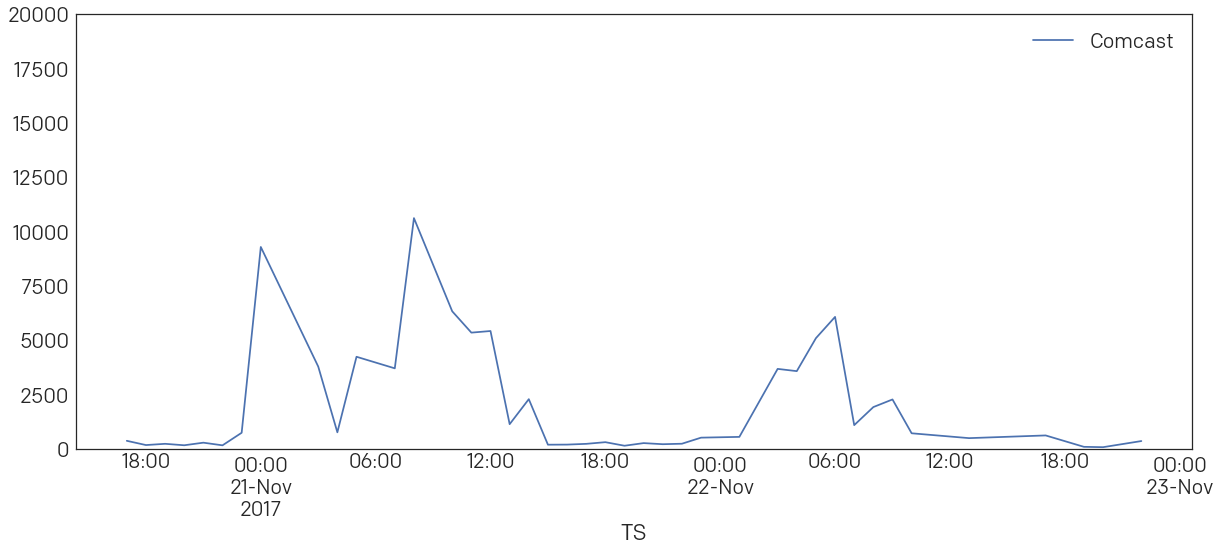

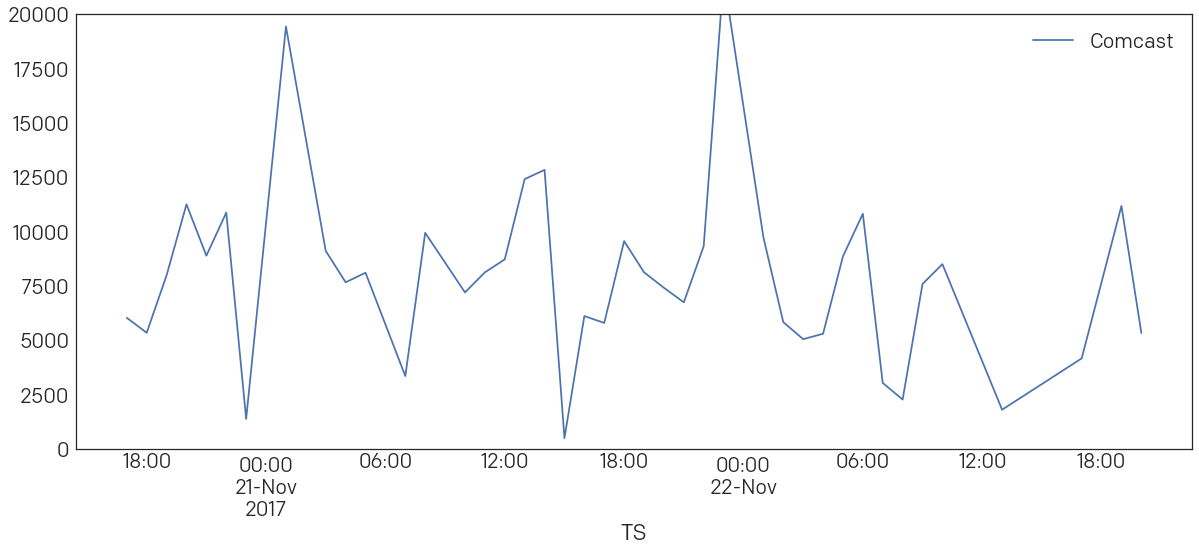

In [4]:
df1_c = df1.copy(True)
df2_c = df2.copy(True)

df1_cc = df1_c[df1_c['TLD'] == 'comcast.net'].resample('h').median()
df2_cc = df2_c[df2_c['TLD'] == 'comcast.net'].resample('h').median()

df1_cc['Speed'].interpolate(inplace=True)
df2_cc['Speed'].interpolate(inplace=True)

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
p1 = df1_cc['Speed'].plot(label="Comcast")
_ = plt.legend()
_ = p1.set(ylim=(0, 20000))

fig, _ = plt.subplots()
fig.set_figwidth(FIG_WIDTH)
fig.set_figheight(FIG_HEIGHT)
p2 = df2_cc['Speed'].plot(label="Comcast")
_ = plt.legend()
_ = p2.set(ylim=(0, 20000))


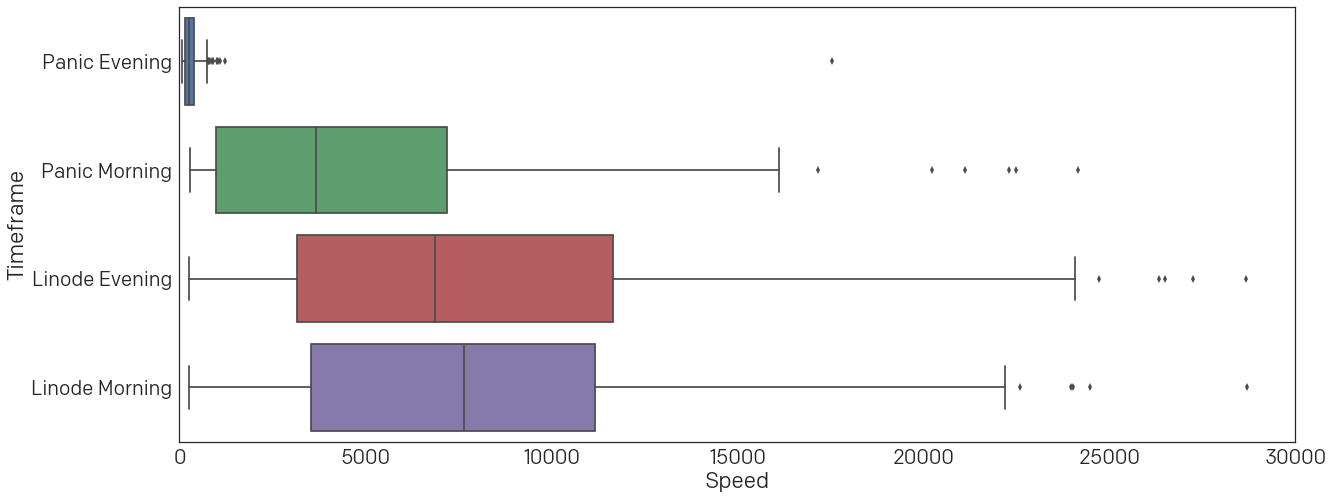

In [5]:
def get_dfs_filtered_by_time(df, label):
    hour = df.index.hour
    selector_l = ((15 <= hour) & (hour <= 23)) | ((0 <= hour) & (hour < 1))
    selector_h = ((1 <= hour) & (hour < 15))
    
    df_l = df[selector_l].assign(Timeframe=f'{label} Evening')
    df_h = df[selector_h].assign(Timeframe=f'{label} Morning')
    
    return df_l, df_h


def plot_by_tld(df1, df2, tld):
    df1 = df1[df1['TLD'] == tld]
    df2 = df2[df2['TLD'] == tld]

    df1_l, df1_h = get_dfs_filtered_by_time(df1, 'Panic')
    df2_l, df2_h = get_dfs_filtered_by_time(df2, 'Linode')
    df_combined = pd.concat([df1_l, df1_h, df2_l, df2_h])

    fig, _ = plt.subplots()
    fig.set_figwidth(FIG_WIDTH)
    fig.set_figheight(FIG_HEIGHT)
    bp = sns.boxplot(data=df_combined, y='Timeframe', x='Speed', orient='h')
    _ = bp.set(xlim=(0, 30000))

plot_by_tld(df1_c, df2_c, 'comcast.net')
# plot_by_tld(df1_c, df2_c, 'sbcglobal.net')
# plot_by_tld(df1_c, df2_c, 'rr.com')
# plot_by_tld(df1_c, df2_c, 'verizon.net')
# plot_by_tld(df1_c, df2_c, 'comcastbusiness.net')
